In [ ]:
# IMPORTACION DE LIBRERIAS NECESARIAS

#!/usr/bin/env python3

import sys, json, base64, warnings, itertools, re
import numpy as np
from pathlib import Path
import networkx as nx
import matplotlib as mpl
# matplotlib.use("Agg") # esto es para que matplotib no saque directamente
%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")        # silenciar avisos de matplotlib

In [ ]:
# ––– 1. Leer argumento ——————————————————————————
# ESTO LO QUE HACE ES DECODIFICAR EL JSON. ESTO ME LO SALTO AHORA Y METO LOS DATOS A MANO EN SIGUIENTE CELDA
# if len(sys.argv) != 2:
#    sys.exit('{"error":"Falta argumento base64"}')
# try:
#    data = json.loads(base64.b64decode(sys.argv[1]).decode())
# except Exception as e:
#    sys.exit(json.dumps({"error": f"JSON inválido: {e}"}))

In [ ]:
# diccionario importado escrito a mano
data={
"Prop1": ["U2"],
"Prop2": ["U3", "U1", "R12"],
"Prop3": ["U5", "U3", "U2"],
"Prop4": ["U5", "U3", "U2", "U6", "R11"],
"Prop5": ["U5", "U3", "U2", "U6","U8", "U9", "U7", "U10"],
"Prop6": ["U7", "U8", "U6", "U3"],
"Prop7": ["U9", "U8", "U5"],
"Prop8": ["U8", "U10", "U7"],
"Prop9": ["U12"]}

In [ ]:
# diccionario con solo las Us
dataU = {
    clave: [x for x in lista if x.startswith("U")]
    for clave, lista in data.items()
}
# diccionario con solo las Rs
dataR = {
    clave: [x for x in lista if x.startswith("R")]
    for clave, lista in data.items()
}

In [ ]:
print(dataR)

{'Prop1': [], 'Prop2': ['R12'], 'Prop3': [], 'Prop4': ['R11'], 'Prop5': [], 'Prop6': [], 'Prop7': [], 'Prop8': [], 'Prop9': []}


In [ ]:
# Paso 1 y 2 iguales: obtenemos 'propuestas' y 'usuarios'
propuestas = sorted(data.keys()) # aqui daría igual que las listásemos nosotros, pero esto es más genérico
usuarios = np.array(['U1','U2','U3','U4','U5','U6','U7','U8','U9','U10','U11','U12'])
# usuarios = sorted({u for lst in dataU.values() for u in lst}) #Esto si no están todos, es más genérico

In [ ]:
# Filtrar propuestas sin apoyos  (requisito C)
propuestas = {k: set(v) for k, v in dataU.items() if v}
if not propuestas:
    sys.exit(json.dumps({"pareto": [], "image": ""}))

{"pareto": ["Prop2", "Prop5", "Prop9"], "image": "pareto.png"}


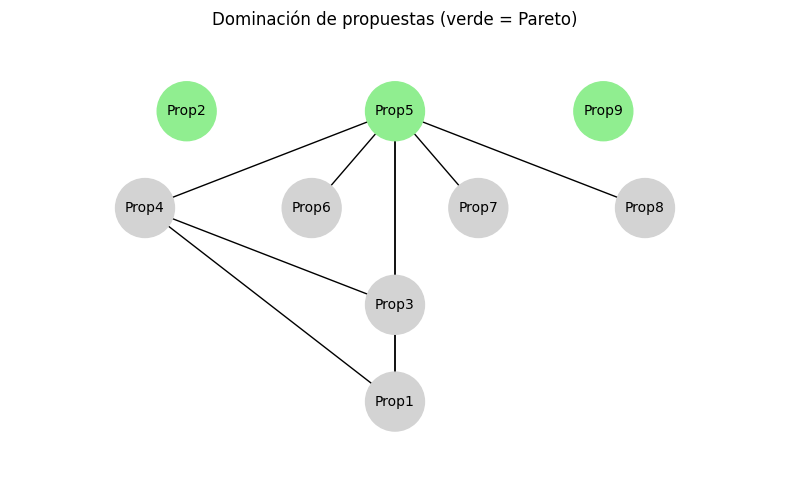

In [ ]:
# ––– PRIMERA PARTE: OBTENCION DEL FRENTE DE PARETO Y GRAFICO
# ––– 2. Aristas de dominación y equivalencia ————————————
G = nx.DiGraph()
G.add_nodes_from(propuestas.keys())
domination_edges = []
equiv_edges      = []        # líneas punteadas azules
for a, b in itertools.combinations(propuestas, 2):
    setA, setB = propuestas[a], propuestas[b]
    if setA == setB:
        equiv_edges.append((a, b))
    elif setB.issubset(setA):
        domination_edges.append((a, b))
    elif setA.issubset(setB):
        domination_edges.append((b, a))
G.add_edges_from(domination_edges)

# ––– 3. Frente de Pareto ——————————————————————————
pareto = [n for n in G if G.in_degree(n) == 0]

# ––– 4. Calcular “profundidad” (nivel) para layout ————————
depth = {}
def nivel(n):
    if n in depth:
        return depth[n]
    preds = list(G.predecessors(n))
    depth[n] = 0 if not preds else max(nivel(p) for p in preds) + 1
    return depth[n]
for nodo in G:
    nivel(nodo)
# Asegurar mismo nivel para propuestas equivalentes
for a, b in equiv_edges:
    mismo = min(depth[a], depth[b])
    depth[a] = depth[b] = mismo
# ––– 5. Coordenadas manuales —————————————————————————
levels = {}
for n, lvl in depth.items():
    levels.setdefault(lvl, []).append(n)
pos = {}
for lvl, nodes in levels.items():
    nodes = sorted(nodes)         # opcional, para orden determinista
    N = len(nodes)
    # Usamos N+1 “intervalos” y colocamos en 1/(N+1), 2/(N+1), …, N/(N+1)
    step = 1 / max(N-1,1)
    for i, n in enumerate(nodes):
        if N == 1:
            # Si hay un solo nodo, centrarlo en x = 0.5
            x = 0.5
        else:
            # Si hay varios nodos, repartirlos en (1/(N+1), ..., N/(N+1))
            x = (i + 1) / (N + 1)
        pos[n] = (x, -lvl)

# ––– 6. Dibujar ——————————————————————————————————————
node_colors = ["lightgreen" if n in pareto else "lightgray" for n in G]
plt.figure(figsize=(8, 5))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=10)

# Aristas de dominación (negras con flecha)
nx.draw_networkx_edges(G, pos, edgelist=domination_edges,
                       arrows=True, arrowstyle='-|>', edge_color='black')
# Líneas de equivalencia (azul punteado, sin flecha) – requisito B
if equiv_edges:
    nx.draw_networkx_edges(G, pos, edgelist=equiv_edges,
                           arrows=False, style='dashed', edge_color='blue')
plt.title("Dominación de propuestas (verde = Pareto)")
plt.axis("off")
plt.margins(0.2)             # requisito D: margen alrededor
plt.tight_layout()
# plt.imshow(matriz, cmap='gray', interpolation='none')
plt.savefig("pareto.png", dpi=300)
output = Path("pareto.png")
print(json.dumps({"pareto": pareto, "image": output.name}))

In [ ]:
print(propuestas)

{'Prop1': {'U2'}, 'Prop2': {'U3', 'U1'}, 'Prop3': {'U3', 'U5', 'U2'}, 'Prop4': {'U6', 'U3', 'U5', 'U2'}, 'Prop5': {'U6', 'U3', 'U7', 'U9', 'U8', 'U5', 'U10', 'U2'}, 'Prop6': {'U6', 'U3', 'U8', 'U7'}, 'Prop7': {'U9', 'U5', 'U8'}, 'Prop8': {'U8', 'U7', 'U10'}, 'Prop9': {'U12'}}


In [ ]:
# ––– SEGUNDA PARTE: CÁLCULO DE MATRICES Y FUNCIONES INCLUSION Y COMPARTICION
# Matrices simples U y R (no las uso)
rechazos = np.array(['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10','R11','R12'])
matriz_U = np.zeros((len(propuestas), len(usuarios)), dtype=int) # matriz a ceros
matriz_R = np.zeros((len(propuestas), len(rechazos)), dtype=int) # matriz a ceros
for i, prop in enumerate(propuestas):
    for usuario in dataU[prop]:
        j = np.where(usuarios == usuario)[0]
        if j.size > 0:
            matriz_U[i, j[0]] = 1
    for usuario in dataR[prop]:
        j = np.where(rechazos == usuario)[0]
        if j.size > 0:
            matriz_R[i, j[0]] = 1
# CALCULO DE FUNCIONES DE INCLUSIÓN Y COMPARTICIÓN ENTRE PROPUESTAS
def inclusion(propA, propB, dataU):
    # Devuelve el porcentaje de usuarios de propA que también apoyan propB, si no hay apoyos a propA --> 0
    usuariosA = set(dataU.get(propA, []))
    usuariosB = set(dataU.get(propB, []))
    if not usuariosA:
        return 0.0
    interseccion = usuariosA & usuariosB
    return len(interseccion) / len(usuariosA)
def comparticion(propA, propB, dataU):
  return (inclusion(propA, propB, dataU) + inclusion(propB, propA, dataU))/2
# CALCULO DE MATRICES DE INCLUSIÓN Y COMPARTICIÓN ENTRE PROPUESTAS
matriz_I = np.zeros((len(propuestas), len(propuestas)), dtype=float) # matriz a ceros
propuestas = sorted(dataU.keys())
for i in range(len(propuestas)):
    for j in range(len(propuestas)):
      matriz_I[i,j]=format(inclusion(propuestas[i],propuestas[j],dataU), '.2f')
matriz_C = np.zeros((len(propuestas), len(propuestas)), dtype=float) # matriz a ceros
propuestas = sorted(dataU.keys())
for i in range(len(propuestas)):
    for j in range(len(propuestas)):
      matriz_C[i,j]=format(comparticion(propuestas[i],propuestas[j],dataU), '.2f')
# FUNCIÓN PARA EL DIBUJO DE UNA MATRIZ
c = plt.get_cmap('RdYlGn') # Parto del RdYlGn original
cols = c(np.linspace(0,1,256)) # Sustituyo el verde del valor máximo por uno más claro:
cols[-1] = mpl.colors.to_rgba('lightgreen')
cmap_mod = mpl.colors.ListedColormap(cols, name='RdYlGn_light') # Nuevo colormap
def dibujar_matriz(M, propuestas, usuarios, cmap=cmap_mod, figsize=(5, 4), dpi=100):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    im = ax.imshow(M, cmap=cmap, aspect='equal', origin='upper')     # Mostrar la matriz
    ax.set_xticks(np.arange(len(usuarios)))     # Ticks y etiquetas
    ax.set_yticks(np.arange(len(propuestas)))
    ax.set_xticklabels(usuarios)
    ax.set_yticklabels(propuestas)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(M.shape[0]): # Anotar cada celda con su valor
        for j in range(M.shape[1]):
            ax.text(j, i, f"{M[i, j]:.2f}",
                    ha="center", va="center")
    ax.set_xticks(np.arange(-.5, M.shape[1], 1), minor=True)     # Cuadrícula ligera
    ax.set_yticks(np.arange(-.5, M.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)     # Colorbar
    plt.tight_layout()
    plt.show()

In [ ]:
# EJEMPLO DE DIBUJO DE UNA MATRIZ (INCLUSION DE PROPUESTAS EN OTRAS PROPUESTAS)
dibujar_matriz(matriz_I, propuestas, propuestas, cmap='RdYlGn',)


In [ ]:
dataP = { key: dataU[key] for key in pareto if key in dataU }
print(dataP)


{'Prop2': ['U3', 'U1'], 'Prop5': ['U5', 'U3', 'U2', 'U6', 'U8', 'U9', 'U7', 'U10'], 'Prop9': ['U12']}


In [ ]:
print(pareto)

['Prop2', 'Prop5', 'Prop9']


In [ ]:
matriz_CP = np.zeros((len(pareto), len(pareto)), dtype=float) # matriz a ceros
for i in range(len(pareto)):
    for j in range(len(pareto)):
        matriz_CP[i,j]=format(inclusion(pareto[j],pareto[i],dataP), '.2f')
dibujar_matriz(matriz_CP, pareto, pareto, cmap='RdYlGn_r',)

In [ ]:
# ––– TERCERA PARTE: ESTADÍSTICAS EN EL FRENTE DE PARETO
estadisticas = ""
estadisticas = f"\n"
estadisticas += f"Nº de propuestas en el frente de Pareto: {len(pareto)}\n"
apoyos = np.array(['U1','U2','U3','U4','U5','U6','U7','U8','U9','U10','U11','U12']) #sustituir por algo genérico del grupo de debate
estadisticas  += f"Nº total de participantes de grupo de debate: {len(apoyos)}\n"
rechazos = np.array(['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10','R11','R12']) #sustituir por algo genérico del grupo de debate

dataP = {key: data[key] for key in pareto if key in data}
ids = set()
for votos in dataP.values():
    for v in votos:
        m = re.match(r"^[UR](\d+)$", v) # Extraer identificador numérico tras 'U' o 'R'
        if m:
           ids.add(int(m.group(1)))
totalUR=len(ids)
estadisticas  += f"Nº de usuarios distintos que han apoyado/rechazado las propuestas del frente: {totalUR}\n"

dataPU = {clave: [x for x in lista if x.startswith("U")] for clave, lista in dataP.items()}
ids = set()
for votos in dataPU.values():
    for v in votos:
        m = re.match(r"^[U](\d+)$", v) # Extraer identificador numérico tras 'U' o 'R'
        if m:
           ids.add(int(m.group(1)))
totalU=len(ids)
estadisticas  += f"Nº de usuarios distintos que han apoyado las propuestas del frente: {totalU}\n"

dataPR = {clave: [x for x in lista if x.startswith("R")] for clave, lista in dataP.items()}
ids = set()
for votos in dataPR.values():
    for v in votos:
        m = re.match(r"^[R](\d+)$", v) # Extraer identificador numérico tras 'U' o 'R'
        if m:
           ids.add(int(m.group(1)))
totalR=len(ids)
estadisticas  += f"Nº de usuarios distintos que han rechazado las propuestas del frente: {totalR}\n"

pct_apoyo = {prop: round(len(set(usuarios))*100/ totalUR, 2) for prop, usuarios in dataPU.items()}
pct_rechazo = {prop: round(len(set(rechazos))*100/ totalUR, 2) for prop, rechazos in dataPR.items()}
pct_mix = {prop: [pct_apoyo.get(prop, 0), pct_rechazo.get(prop, 0)] for prop in set(pct_apoyo) | set(pct_rechazo)}
orden_claves = sorted(pct_mix.keys(),key=lambda k: (-pct_mix[k][0], pct_mix[k][1]))
pct_mix_ordenado = {k: pct_mix[k] for k in orden_claves}
for prop, (apoyo, rechazo) in pct_mix_ordenado.items():
	estadisticas  += f"La propuesta {prop} tiene un apoyo del {apoyo}% y un rechazo del {rechazo}%\n"

# print(data)
# print(dataP)
# print(dataPU)
# print(dataPR)
print(estadisticas)


Nº de propuestas en el frente de Pareto: 3
Nº total de participantes de grupo de debate: 12
Nº de usuarios distintos que han apoyado/rechazado las propuestas del frente: 10
Nº de usuarios distintos que han apoyado las propuestas del frente: 10
Nº de usuarios distintos que han rechazado las propuestas del frente: 1
La propuesta Prop5 tiene un apoyo del 80.0% y un rechazo del 0.0%
La propuesta Prop2 tiene un apoyo del 20.0% y un rechazo del 10.0%
La propuesta Prop9 tiene un apoyo del 10.0% y un rechazo del 0.0%

